__[Open and try this file online (Colab)](https://colab.research.google.com/github/djekra/bludwig/blob/main/jupyter/40_MNIST/_10_Train_MNIST.ipynb)__

In [1]:
# blab init
try:
    import blab
except ImportError as e:
    !pip install --quiet blab
    import blab    
startup_notebook = blab.blab_startup()
%run $startup_notebook 

blab init
environment['in_colab']     = False
environment['dropbox_path'] = /home/me/Dropbox
environment['lib_path']     = /home/me/Dropbox/31_Projekte/01_Python/libs
Start Time: 23:20:47


# Train MNIST

In [2]:
# Settings

dataset_name    = 'mnist'       # Which dataset shall be loaded?
experiment_name = 'mnist'       # Base of the model names
mode            = 'S'           # mode: C=cleanup, T=train, S=show 
#train_jobs      = [ 0, 1, 2, 3 ]   # Which models shall be trained?
verbose         = False    
predict_model   =   1           # Which model shall be used for predictions?
predicts_size   = 100           # How many predictions should be created?
  
gdrive_base     = 'drive/MyDrive/Colab'
bgc('Beige')  

In [3]:
# Colab? >> Install the latest version of Ludwig
if environment['in_colab']:
  !pip uninstall -y tensorflow --quiet
  !python -m pip install git+https://github.com/ludwig-ai/ludwig.git --quiet 
  !pip install ptitprince --quiet 
  !pip install bludwig --quiet 

In [4]:
# cleanup?
if not 'is_neustart' in locals() or mode == 'C': 
    is_neustart = True
    if not mode == 'S': # show
        try:
            !rm -rf results
            !rm *.meta.json
            !rm *.hdf5    
            !rm *.temp.pickle        
            !rm .lock_preprocessing
        except:
            pass
else:
    is_neustart = False    

if mode == 'C':
    raise Stop
else:
    bgc('WhiteSmoke')
    
print('is_neustart:',is_neustart)

is_neustart: True


In [5]:
# import 
import pandas as pd
import pandasklar as pak
grid = pak.grid
import bludwig

%matplotlib inline
import matplotlib.pyplot as plt

## Data

In [6]:
# load_dataset
data_df, dataset_loader = bludwig.load_dataset(dataset_name)


mnist 1.0
The MNIST database of handwritten digits, available from this page,
has a training set of 60,000 examples, and a test set of 10,000 examples.
It is a subset of a larger set available from NIST. The digits have been
size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and
pattern recognition methods on real-world data while spending minimal
efforts on preprocessing and formatting.
http://yann.lecun.com/exdb/mnist/

output_features: [{'name': 'label', 'type': 'category'}]


In [7]:
# examine
print(data_df.shape[0], 'records for training, validation and test')
pak.sample(data_df,10)

70000 records for training, validation and test


,label,image_path,split
0,0,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0
2498,0,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0
5923,1,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0
25358,4,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0
40312,6,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0
53828,8,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0
59202,9,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0
60400,0,/home/me/.ludwig_cache/mnist_1.0/processed/tes...,2
60436,0,/home/me/.ludwig_cache/mnist_1.0/processed/tes...,2
69999,9,/home/me/.ludwig_cache/mnist_1.0/processed/tes...,2


In [8]:
# analyse_cols
analyse = bludwig.analyse_cols(data_df, dataset_loader)
analyse

,col_name,is_output_feature,feature_type,datatype_short,datatype_identified,mem_usage,nunique,ndups,vmin,vmax,n
0,label,True,category,string,string,580,10,9990,0,9,10000
1,image_path,False,image,string,string,1194,10000,0,/home/me/.ludwig_cache/mnist_1.0/processed/tes...,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,10000


## configs

In [9]:
# Automatically generated 
# (without the provided config)
configs = bludwig.configs(data_df)

# Automatically generated / provided configs
#configs = bludwig.configs(data_df, dataset_loader)

for i, c in enumerate(configs):
    print('\n====== config for model {} ======\n'.format( experiment_name + '_' + str(i)))
    print(c)
    print('\n\n')


====== config for model mnist_0 ======

input_features:
- name: image_path
  type: image
output_features:
- name: label
  type: category






## Add Image Vectors & config

In [10]:
# create image_array 
if not 'image_array' in data_df.columns:
    data_df[ 'image_array'] = data_df.image_path.apply( plt.imread )

    # image_array Beispiel anschauen
    i = data_df.sample(1).iloc[0].image_array
    print('shape =', bpy.shape(i))
    print(i[10:12])    

shape = (28, 28)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.05490196 0.36078432 0.99215686
  0.63529414 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.11372549 0.39607844 0.42745098
  0.33333334 0.33333334 0.33333334 0.78431374 0.99215686 0.92156863
  0.08235294 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


In [11]:
# create image_vector  (whitespace separated numerical values)
def make_imagevector(imagearray):
    result = str(list(bpy.flatten( imagearray )))
    result = result.replace('[','')
    result = result.replace(']','')    
    result = result.replace(',','')       
    return result

if not 'image_vector' in data_df.columns:
    data_df[ 'image_vector']  = data_df.image_array.apply(  make_imagevector )

    # image_vector Beispiel anschauen
    i = data_df.sample(1).iloc[0].image_vector
    print('shape =', len(i.split()))
    print(i[1000:-1000])    

    

shape = 784
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.08235294 0.9490196 0.6313726 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.11372549 0.99607843 0.5529412 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.11372549 0.99607843 0.37254903 0.0 0.0 0.0 0.0 0.0 0.0 0.02745098 0.11372549 0.019607844 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.34509805 0.99607843 0.1254902 0.0 0.0 0.0 0.0 0.0 0.10980392 0.80784315 0.99607843 0.78039217 0.078431375 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6666667 0.99607843 0.0 0.0 0.0 0.0 0.0 0.12156863 0.85882354 0.99607843 0.99607843 0.99607843 0.9098039 0.09803922 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6784314 0.8235294 0.0 0.0 0.0 0.0 0.09411765 0.8509804 0.6784314 0.6 0.47843137 0.3882353 0.99607843 0.5372549 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.9411765 0.6392157 0.0 0.0

In [12]:
# Helper function to display images

def plotDigitGrid(X,y,idxs,y_hat=None):
    plt.rcdefaults()
    plt.figure(figsize=(14,12))

    for i in range(len(idxs)):
        plt.subplot(5,6,i+1)
        
        if y_hat is None:
            plt.title('Label: {label}'.format(label=y[idxs[i]]))
        else:
            plt.title("Label: {label}  Pred: {pred}".format(label=y[idxs[i]], pred=y_hat[idxs[i]]))

        plt.imshow(X[idxs[i]], cmap='Greys')
        plt.tick_params(
            axis='both',       # changes apply to the x-axis and y-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # tick marks on bottom side are off
            left=False,        # tick marks on left side are off
            labelleft=False,   # label on left side are off
            labelbottom=False) # labels along the bottom edge are off
        plt.subplots_adjust(hspace=0.5)

    plt.show()

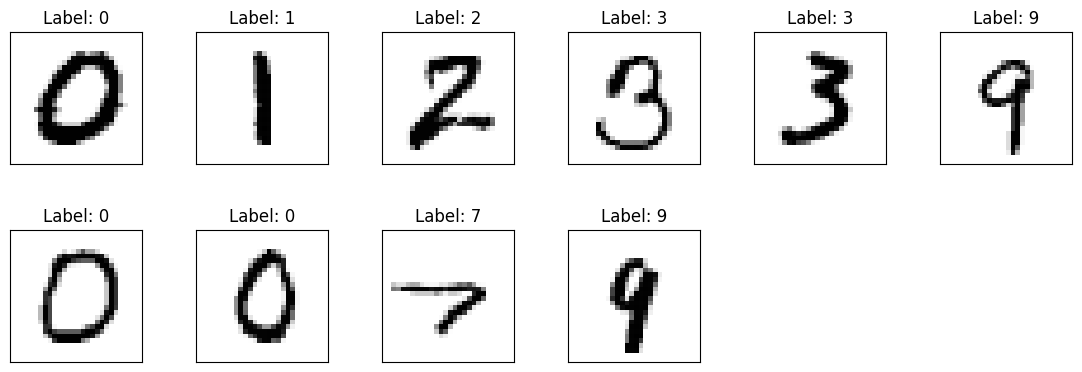

In [13]:
# plot sample images
sample_df = pak.sample(data_df,10)
plotDigitGrid(sample_df.image_array, sample_df.label, sample_df.index)

In [14]:
# analyse_cols
cols = ['label','image_vector']
analyse = bludwig.analyse_cols(data_df[cols], dataset_loader)
analyse

,col_name,is_output_feature,feature_type,datatype_short,datatype_identified,mem_usage,nunique,ndups,vmin,vmax,n
0,label,True,category,string,string,580,10,9990,0,9,10000
1,image_vector,False,vector,object,string,42484,10000,0,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,10000


In [15]:
# Add vector config
configs += bludwig.configs(data_df[cols])

for i in [1]:
    c = configs[i]
    print('\n====== config for model {} ======\n'.format( experiment_name + '_' + str(i)))
    print(c)
    print('\n\n')


====== config for model mnist_1 ======

input_features:
- name: image_vector
  type: vector
output_features:
- name: label
  type: category






## Add Manual configs

In [16]:
# CNN

config_2 = """

input_features:
- name: image_path
  type: image
  encoder: stacked_cnn  
  preprocessing:
    num_processes: 4
  conv_layers:
  - num_filters: 32
    filter_size: 3
    pool_size: 2
    pool_stride: 2
  - num_filters: 64
    filter_size: 3
    pool_size: 2
    pool_stride: 2
    dropout: 0.4
  fc_layers:
  - output_size: 128
    dropout: 0.4
    
  
output_features:
- name: label
  type: category
  
trainer:
  epochs: 10

"""

In [17]:
# Image Feature

config_3 = """

input_features:
    - name: image_path
      type: image    
      preprocessing:
        num_processes: 4
 
output_features:
    - name: label
      type: category
      
trainer:
    epochs: 10
  
"""

In [18]:
# add configs
configs += [config_2, config_3]

for i in [2,3]:
    c = configs[i]
    print('\n====== config for model {} ======\n'.format( experiment_name + '_' + str(i)))
    print(c)
    print('\n\n')


====== config for model mnist_2 ======



input_features:
- name: image_path
  type: image
  encoder: stacked_cnn  
  preprocessing:
    num_processes: 4
  conv_layers:
  - num_filters: 32
    filter_size: 3
    pool_size: 2
    pool_stride: 2
  - num_filters: 64
    filter_size: 3
    pool_size: 2
    pool_stride: 2
    dropout: 0.4
  fc_layers:
  - output_size: 128
    dropout: 0.4
    
  
output_features:
- name: label
  type: category
  
trainer:
  epochs: 10






====== config for model mnist_3 ======



input_features:
    - name: image_path
      type: image    
      preprocessing:
        num_processes: 4
 
output_features:
    - name: label
      type: category
      
trainer:
    epochs: 10
  






## Initialize

In [19]:
# bludwig initialize
if mode == 'T':  
    ludwig_job = bludwig.LudwigJob( configs=configs, experiment_name=experiment_name, verbose=False) 

In [20]:
# bludwig initialize and load
if mode == 'S':  
    ludwig_job = bludwig.LudwigJob() 
    ludwig_job.load_from_results()
    #print(ludwig_job)

## Train

In [21]:
# train and evaluate
out = None
if mode == 'T':  
    ludwig_job.experiment(data_df)
    out = ludwig_job.train_log_to_csv()
else:
    out = 'No training'
out

'No training'

## Evaluate

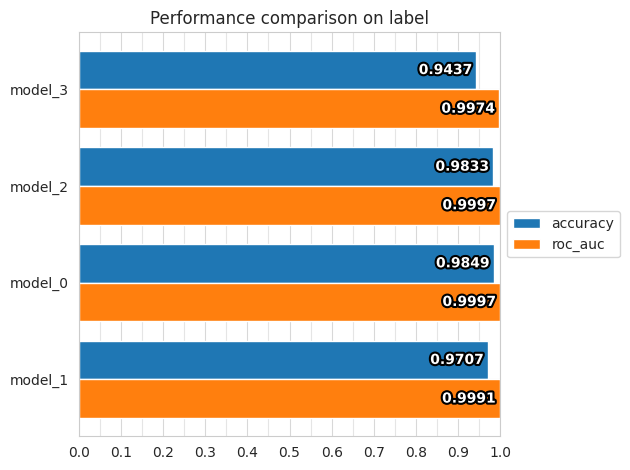

In [22]:
# compare_performance
ludwig_job.compare_performance()

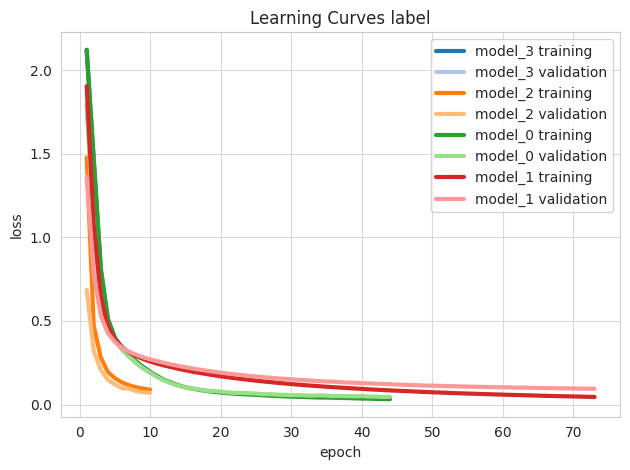

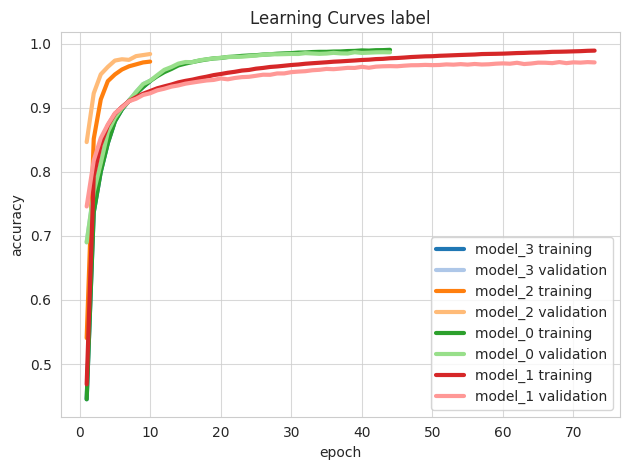

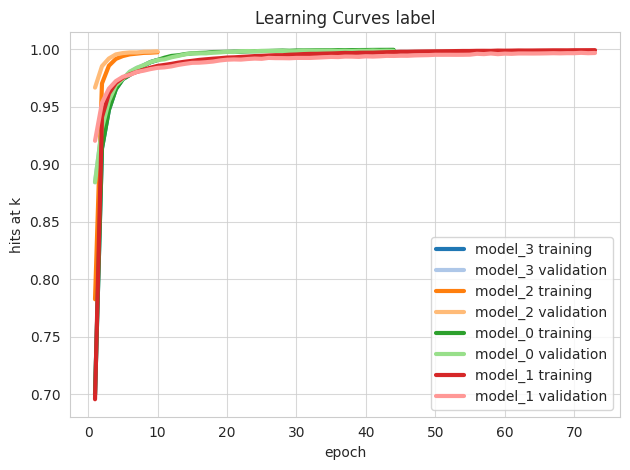

In [23]:
# learning_curves
ludwig_job.learning_curves()

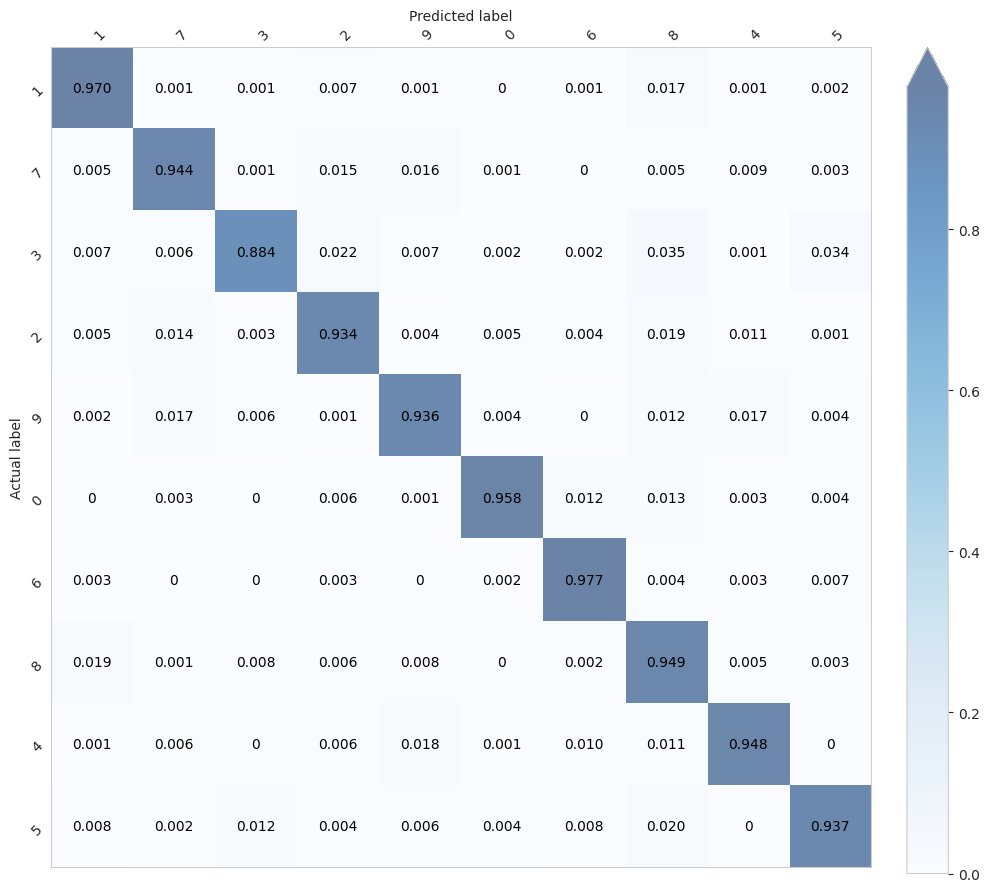

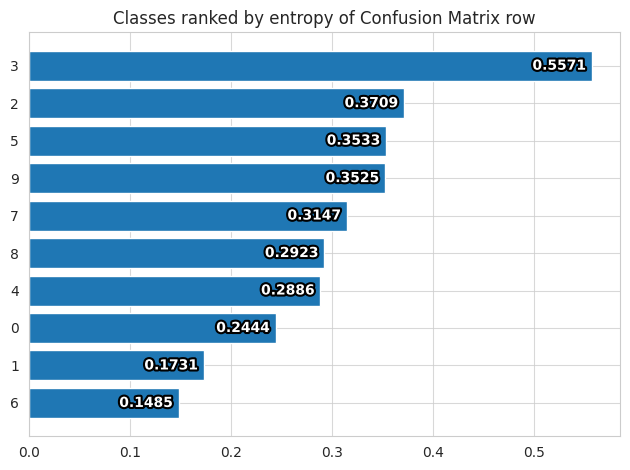

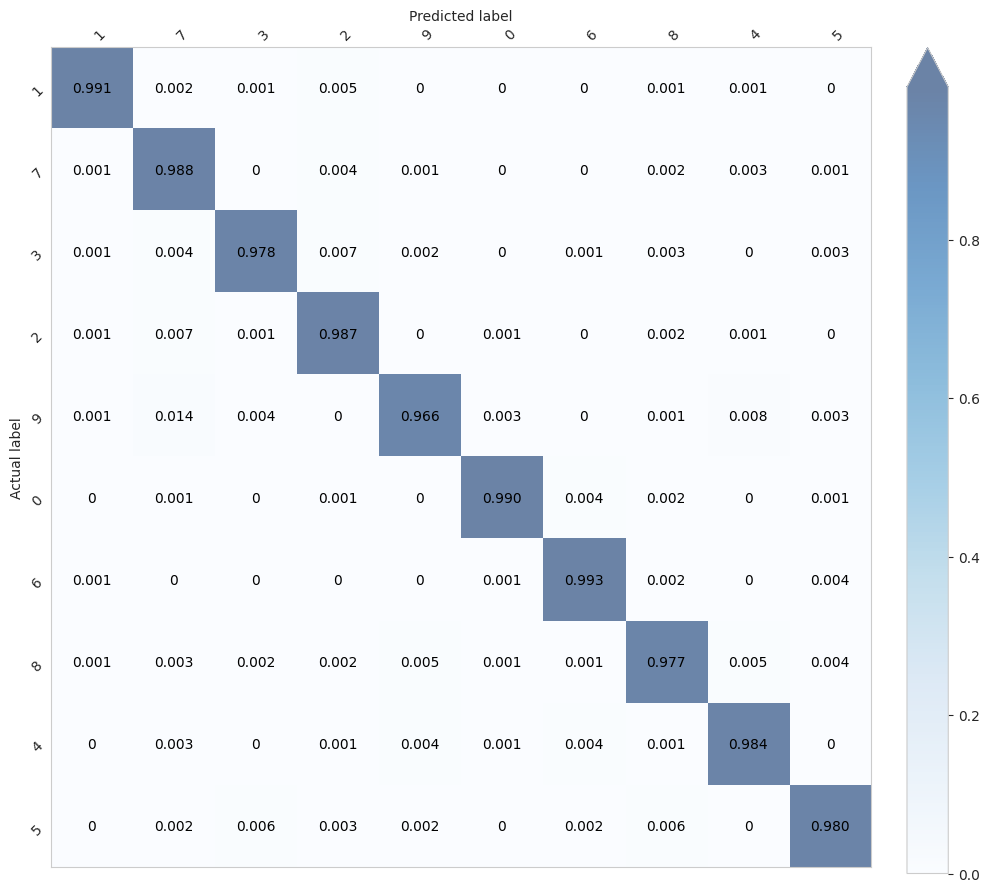

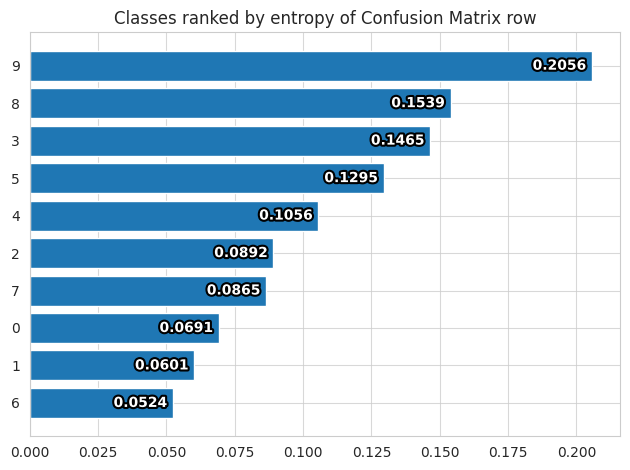

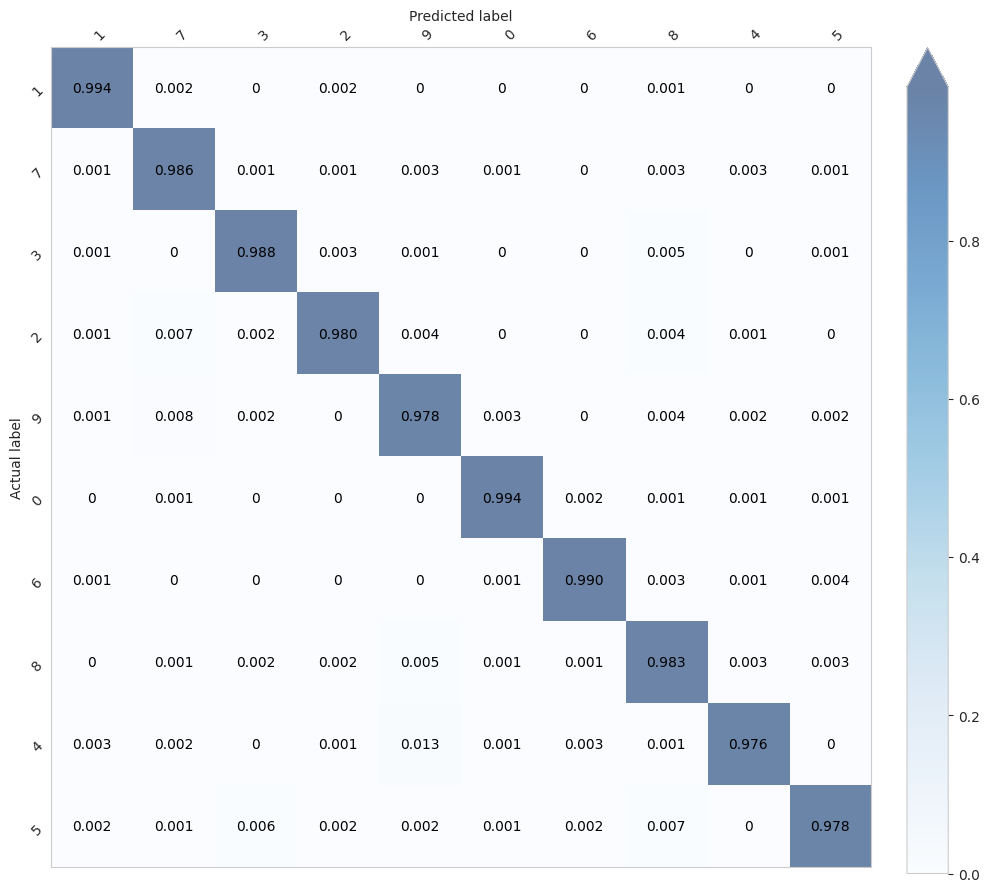

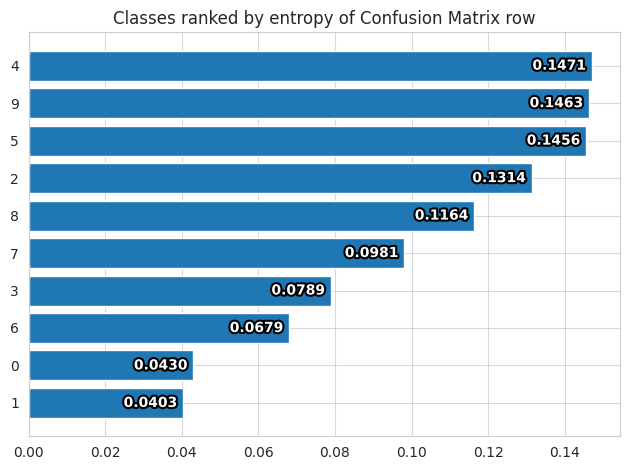

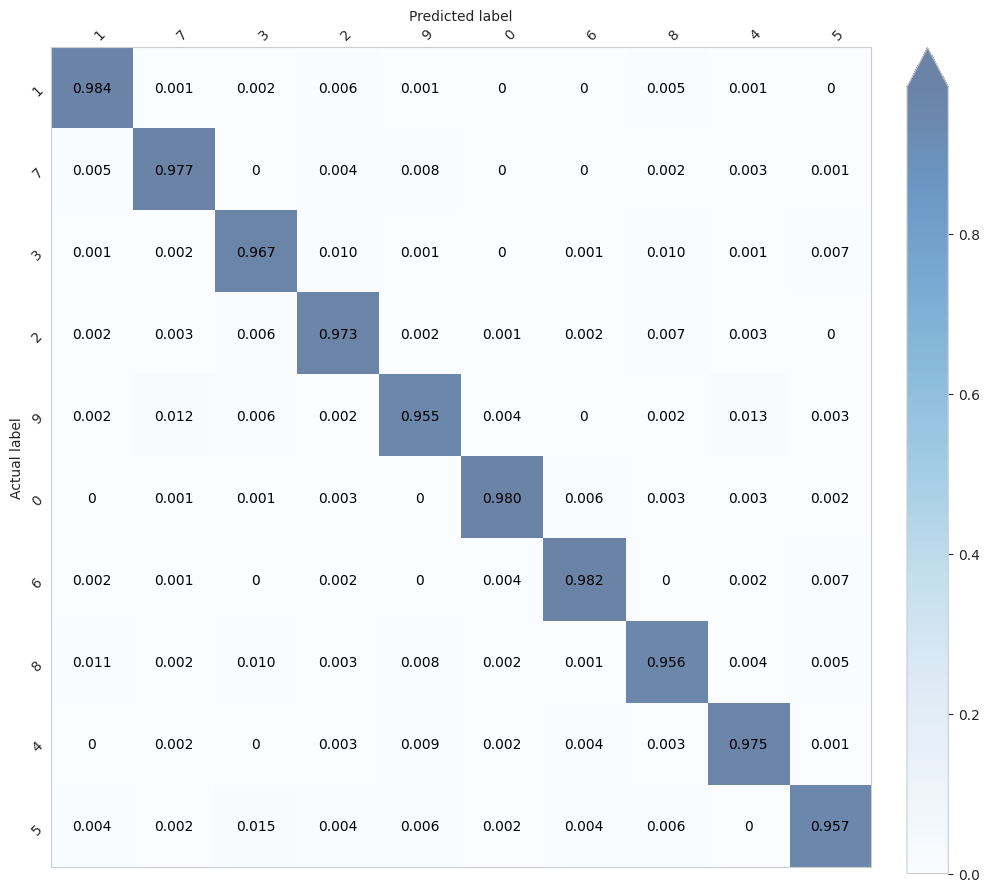

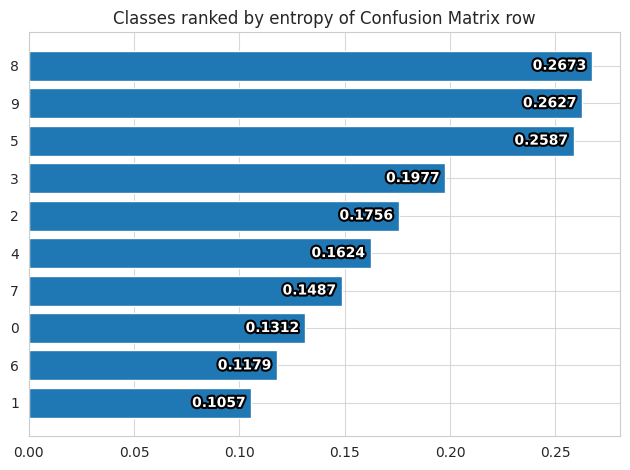

In [24]:
# confusion_matrix
#ludwig_job.load_model(0)
ludwig_job.confusion_matrix()

In [25]:
# roc_curves
ludwig_job.roc_curves()

No roc_curve found


## print_models

In [26]:
# print 
print(ludwig_job)

LudwigJob object
        experiment_name:     model
        output_feature_name: label
        train_jobs:          [3, 2, 0, 1]
        model_names:         ['model_3', 'model_2', 'model_0', 'model_1']
        model_paths:         ['results/mnist_3_run/model', 'results/mnist_2_run/model', 'results/mnist_0_run/model', 'results/mnist_1_run/model']        
        output_dirs:         ['results/mnist_3_run', 'results/mnist_2_run', 'results/mnist_0_run', 'results/mnist_1_run']
        model_no:            0   
        cuda:                True             
        


In [27]:
ludwig_job.print_models()

### model_1 ###
Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
ECD                                                          [2, 784]                  [2, 256]                  --                        True
├─LudwigFeatureDict: 1-1                                     --                        --                        --                        True
│    └─ModuleDict: 2-1                                       --                        --                        --                        True
│    │    └─VectorInputFeature: 3-1                          [2, 784]                  [2, 256]                  --                        True
│    │    │    └─DenseEncoder: 4-1                           [2, 784]                  [2, 256]                  --                        True
│    │    │    │    └─FCStack: 5-1                           [2, 784]                  [2, 256]                  --

## Predict

In [28]:
# load_model
print('predict_model:',predict_model)
ludwig_job.load_model(predict_model)

# data
data_sample = pak.sample(data_df, predicts_size)

# predict
data_sample = ludwig_job.predict(data_sample)
data_sample

predict_model: 1


,label,label_pred,image_path,split,image_array,image_vector,label_prob,label_prob,label_prob_1,label_prob_7,label_prob_3,label_prob_2,label_prob_9,label_prob_0,label_prob_6,label_prob_8,label_prob_4,label_prob_5
0,0,0,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,"[2.614445520521258e-06, 1.6337886336259544e-05...",0.999755,0.000003,0.000016,1.515861e-07,0.000080,0.000050,0.999755,8.174882e-05,0.000004,8.520697e-06,0.000002
1064,0,0,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,"[5.71847567698569e-06, 0.00021704142272938043,...",0.998205,0.000006,0.000217,4.764038e-06,0.000309,0.000311,0.998205,7.623202e-04,0.000020,2.416947e-05,0.000141
1724,0,0,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,"[0.0003706951974891126, 0.001193102216348052, ...",0.978020,0.000371,0.001193,1.761399e-04,0.003451,0.001517,0.978020,2.810169e-03,0.011198,4.680468e-04,0.000797
2426,0,0,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,"[0.00016636846703477204, 0.0005604653852060437...",0.996276,0.000166,0.000560,8.271170e-05,0.001300,0.000106,0.996276,4.419666e-04,0.000946,4.403762e-05,0.000076
3237,0,0,/home/me/.ludwig_cache/mnist_1.0/processed/tra...,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,"[0.036205533891916275, 0.017426619306206703, 0...",0.800057,0.036206,0.017427,2.104546e-03,0.007001,0.001285,0.800057,6.877004e-02,0.050779,1.416355e-02,0.002208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67559,7,7,/home/me/.ludwig_cache/mnist_1.0/processed/tes...,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,"[0.0001534994225949049, 0.9815263152122498, 0....",0.981526,0.000153,0.981526,2.912388e-03,0.014740,0.000447,0.000053,1.341934e-06,0.000095,8.908009e-07,0.000070
67608,7,7,/home/me/.ludwig_cache/mnist_1.0/processed/tes...,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,"[3.13630880555138e-05, 0.9987799525260925, 0.0...",0.998780,0.000031,0.998780,1.198232e-04,0.000334,0.000683,0.000031,1.215566e-07,0.000004,1.384211e-06,0.000016
69354,9,9,/home/me/.ludwig_cache/mnist_1.0/processed/tes...,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,"[0.005729722790420055, 0.05308597534894943, 0....",0.760044,0.005730,0.053086,1.127003e-02,0.005030,0.760044,0.001241,4.775978e-04,0.010466,1.485876e-01,0.004067
69526,9,9,/home/me/.ludwig_cache/mnist_1.0/processed/tes...,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,"[2.05256083063432e-06, 0.001291227643378079, 0...",0.996569,0.000002,0.001291,8.793547e-04,0.000020,0.996569,0.000009,6.784224e-08,0.000077,9.183486e-04,0.000234


In [29]:
if not environment['in_colab']:
    raise Stop

Stop Time:  23:21:42
Elapsed:    54 secs


## Colab: Copy back

In [ ]:
# mount
if environment['in_colab']:
    from google.colab import drive
    drive.mount('/content/drive')  

In [ ]:
# mount
if environment['in_colab']:
    from google.colab import drive
    drive.mount('/content/drive')  

In [ ]:
if environment['in_colab']:
    !ls

In [ ]:
if environment['in_colab']:
    !ls results

In [ ]:
# results: copy to GDrive
if environment['in_colab']:
  results_path = gdrive_base + '/results'
  !cp -a results $results_path 
  !cp train_log*.csv $gdrive_base 

In [ ]:
if environment['in_colab']:
    print('Copy back manually:')
    print('1) This ipynb-File, if changed')
    print('2) results directory')
    print('3) train_log file')    
else:
    print('finished')

In [ ]:
raise Stop